# pET19K HF alpha (Hagfish Alpha) Protein Production Limits

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## 4. Create the Alpha Transcription Reaction

Complete the steps necessary to create the Alpha Transcription Reaction

In [4]:
locus_id = 'Alpha'
left_pos =  None
right_pos = None
seq = 'ATGAGCATCAGCCAGACCGTTAGCAAAAGCTATACCAAAAGCGTTAGCCGTGGTGGTCAGGGTGTTAGCTATAGCCAGAGCAGCAGCCATAAAGTTGGTGGTGGTAGCGTTCGTTATGGCACCACCTATAGCAGCGGTGGTATTAGCCGTGTTCTGGGTTTTCAAGGTGGTGCAGGCGGTGCAGCAAGCGCAGGTTTTGGTGGTAGTGTTGGTGGTTCAGGTCTGAGCCGTGTGTTAGGTGGTAGCATGGTTAGCGGTTATCGTAGCGGTATGGGTGTTGGCGGTCTGAGTCTGAGCGGCACCGCAGGTCTGCCGGTTAGCCTGCGTGGTGTTGGTGCAGGTAAAGCACTGCATGCAATTACCAGCGCATTTCGTACACGCGTTGGTGGTCCGGGTACAAGCGTTGGCGGTTATGGTGTGAATTATAGCTTTCTGCCGAGCACAGCAGGTCCGAGCTTTGGTGGCCCTTTTGGCGGTCCGTTTGGAGGTCCTTTTGGTGGACCATTAGGTCCGGGTTATATTGATCCGGCAACACTGCCGAGTCCGGATACCGTTCAGCATACCCGTATTCGTGAAAAACAGGATCTGCAGACACTGAATACCAAATTTGCCAATCTGGTTGATCAGGTTCGTACCCTGGAACAGCATAATGCAATTCTGAAAGCACAGATTAGCATGATTACCAGTCCGAGCGATACACCGGAAGGTCCGGTTAATACCGCAGTTGTTGCAAGCACCGTTACCGCAACCTATAATGCACAGATTGAAGATCTGCGTACCACCAATACCGCACTGCATAGCGAAATTGATCATCTGACAACCATCATCAACGACATCACCACCAAATATGAAGAACAGGTTGAAGTTACCCGTACACTGGAAACCGATTGGAATACCAACAAAGATAACATCGATAACACCTACCTGACCATTGTTGATCTGCAAACCAAAGTTCAAGGTCTGGATGAGCAGATTAATACCACAAAGCAGATTTATAACGCACGTGTTCGTGAAGTTCAGGCAGCAGTTACCGGTGGTCCGACCGCAGCATATAGCATTCGTGTTGATAATACCCATCAGGCCATTGATCTGACCACCTCACTGCAAGAAATGAAAACACATTATGAAGTGCTGGCAACCAAAAGCCGTGAAGAAGCATTTACCCAGGTTCAGCCTCGTATTCAAGAAATGGCAGTGACCGTGCAGGCAGGTCCGCAGGCAATTATTCAGGCAAAAGAACAAATCCACGTGTTCAAACTGCAGATTGATAGCGTTCATCGTGAAATCGATCGTCTGCATCGTAAAAATACCGATGTGGAACGTGAAATTACCGTGATCGAAACCAATATTCATACCCAGAGTGATGAATGGACCAACAATATTAACAGCCTGAAAGTTGATCTGGAAGTGATCAAAAAGCAGATCACCCAGTATGCACGTGATTATCAAGATCTGCTGGCCACAAAAATGAGCCTGGATGTTGAAATTGCAGCCTACAAAAAACTGCTGGATAGCGAAGAAACCCGTATTAGTCATGGTGGTGGCATTACCATTACAACCAATGCAGGCACCTTTCCTGGTGGTCTGAGCGCAGCCCCAGGTGGTGGTGCAAGCTATGCAATGGTTCCGGCAGGCGTTGGAGGTGTTGGTCTGGCAGGCGTAGGTGGTTATGGTTTTCGTAGCATGGGTGGCGGTGGTGGCGTTGGCTATGGTGCCGGTGGCGGAGGTGTAGGTTATGGCGTCGGTGGTGGTTTTGGAGGTGGTATGGGTATGAGCATGAGCCGTATGAGTATGGGTGCAGCAGTTGGCGGTGGCAGCTATGGTAGCGGCAGCGGTTATAGCGGTGGCTTTGGTCTGAGTAGCAGCCGTGCAGGTTATAGTGCAAGCCGTAAAAGCTATTCAAGCGCACGTAGCAGCAGTCGTATCTAT'
strand = None
rna_type = 'mRNA'

building.create_transcribed_gene(me, locus_id, rna_type, seq)
building.add_transcription_reaction(me, 'TU_Alpha', {'Alpha'}, seq)
print(me.reactions.transcription_TU_Alpha.reaction)
me.reactions.transcription_TU_Alpha.update()

469 atp_c + 549 ctp_c + 411 gtp_c + 500 utp_c --> RNA_Alpha + 614.960167029 mRNA_biomass + 1929 ppi_c


/source/cobrame/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found


###  Add the RNAP to the Alpha Transcription Reaction

In [5]:
me.reactions.transcription_TU_Alpha.transcription_data.RNA_polymerase = 'RNAP70-CPLX'
me.reactions.transcription_TU_Alpha.update()

List the transcription data ("transcription_data") associated with the Alpha transcription reaction ("transcription_TU_Alpha").

In [6]:
rxn = me.reactions.transcription_TU_Alpha
data = rxn.transcription_data
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,TU_Alpha
_model,iJL1678b-ME
_parent_reactions,{'transcription_TU_Alpha'}
nucleotide_sequence,ATGAGCATCAGCCAGACCGTTAGCAAAAGCTATACCAAAAGCGTTAGCCGTGGTGGTCAGGGTGTTAGCTATAGCCAGAGCAGCAGCCATAAAGTTGGTGGTGGTAGCGTTCGTTATGGCACCACCTATAGCAGCGGTGGTATTAGCCGTGTTCTGGGTTTTCAAGGTGGTGCAGGCGGTGCAGCAAGCGCAGGTTTTGGTGGTAGTGTTGGTGGTTCAGGTCTGAGCCGTGTGTTAGGTGGTAGCATGGTTAGCGGTTATCGTAGCGGTATGGGTGTTGGCGGTCTGAGTCTGAG...
RNA_products,{'RNA_Alpha'}
RNA_polymerase,RNAP70-CPLX
subreactions,"defaultdict(<class 'int'>, {})"


List the attributes of the Alpha transcription reaction.

In [7]:
rxn = me.reactions.transcription_TU_Alpha
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,transcription_TU_Alpha
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,"{<RNAP RNAP70-CPLX at 0x7f9897758390>: -0.00921844765619026*mu - 0.00360902225739849, <TranscribedGene RNA_Alpha at 0x7f9897884518>: 1, <Metabolite utp_c at 0x7f9897758e10>: -500, <Metabolite atp_c at 0x7f98977589b0>: -469, <Metabolite ctp_c at 0x7f9897758ef0>: -549, <Metabolite gtp_c at 0x7f989..."
_model,iJL1678b-ME
_objective_coefficient,0.0


List the complete reaction associated with the Alpha transcription reaction.

In [8]:
me.reactions.get_by_id('transcription_TU_Alpha').reaction

'0.00921844765619026*mu + 0.00360902225739849 RNAP70-CPLX + 469 atp_c + 549 ctp_c + 411 gtp_c + 500 utp_c --> RNA_Alpha + 614.960167029 mRNA_biomass + 1929 ppi_c'

List the RNAP associated with the Alpha transcription reaction

In [9]:
me.reactions.transcription_TU_Alpha.transcription_data.RNA_polymerase

'RNAP70-CPLX'

## 5. Create the Alpha Translation Reaction

Complete all the steps necessary to create the Alpha Translation Reaction

### Storing information about a translation reaction

In [10]:
data = cobrame.TranslationData('Alpha', me, 'RNA_Alpha', 'protein_Alpha')
data.nucleotide_sequence = seq

### Create translation reaction

By associating the TranslationReaction with its corresponding TranslationData object and running the update function, COBRAme will create a translation reaction for the nucleotide sequence given based on the organisms codon table and prespecified translation machinery.

In [11]:
rxn = cobrame.TranslationReaction('translation_Alpha')
rxn.translation_data = data
me.add_reaction(rxn)

### Updating the translation reaction

Note that this process does not include the ribosome in the reaction.

In [12]:
rxn.update()
print(rxn.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_Alpha + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 48 ala__L_c + 30 arg__L_c + 21 asn__L_c + 24 asp__L_c + 2.88274348422497*(mu + 0.3915)/mu atp_c + 31 gln__L_c + 26 glu__L_c + 102 gly_c + 13 his__L_c + 36 ile__L_c + 38 leu__L_c + 23 lys__L_c + 3.67795106755342*(mu + 0.3915)/mu mRNA_biomass + 14 met__L_c + 15 phe__L_c + 21 pro__L_c + 0.00921844765619026*mu + 0.00360902225739849 ribosome + 66 ser__L_c + 58 thr__L_c + 2 trp__L_c + 26 tyr__L_c + 49 val__L_c --> 2.88274348422497*(mu + 0.3915)/mu adp_c + 2.80499314128944*(mu + 0.3915)/mu amp_c + 3.28345679012346*(mu + 0.3915)/mu cmp_c + 2.45810699588477*(mu + 0.3915)/mu gmp_c + 642.0 - 2.88274348422497*(mu + 0.3915)/mu h2o_c + 2.88274348422497*(mu + 0.3915)/mu h_c + 2.88274348422497*(mu + 0.3915)/mu pi_c + protein_Alpha + 66.69648898000001 protein_biomass + 2.99039780521262*(mu + 0.3915)/mu ump_c


### Incorporate the ribosome

Add the ribosome to the reaction.

In [13]:
ribosome = cobrame.Ribosome('ribosome')
me.add_metabolites([ribosome])
me.reactions.translation_Alpha.update()
print(me.reactions.translation_Alpha.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_Alpha + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 48 ala__L_c + 30 arg__L_c + 21 asn__L_c + 24 asp__L_c + 2.88274348422497*(mu + 0.3915)/mu atp_c + 31 gln__L_c + 26 glu__L_c + 102 gly_c + 13 his__L_c + 36 ile__L_c + 38 leu__L_c + 23 lys__L_c + 3.67795106755342*(mu + 0.3915)/mu mRNA_biomass + 14 met__L_c + 15 phe__L_c + 21 pro__L_c + 0.00921844765619026*mu + 0.00360902225739849 ribosome + 66 ser__L_c + 58 thr__L_c + 2 trp__L_c + 26 tyr__L_c + 49 val__L_c --> 2.88274348422497*(mu + 0.3915)/mu adp_c + 2.80499314128944*(mu + 0.3915)/mu amp_c + 3.28345679012346*(mu + 0.3915)/mu cmp_c + 2.45810699588477*(mu + 0.3915)/mu gmp_c + 642.0 - 2.88274348422497*(mu + 0.3915)/mu h2o_c + 2.88274348422497*(mu + 0.3915)/mu h_c + 2.88274348422497*(mu + 0.3915)/mu pi_c + protein_Alpha + 66.69648898000001 protein_biomass + 2.99039780521262*(mu + 0.3915)/mu ump_c


### Add Subreactions to the Alpha model

Create the subreactions that represent elongation, initiation and termination

In [14]:
elongation = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
initiation = ['Translation_gtp_initiation_factor_InfB', 'Translation_initiation_factor_InfA', 
              'Translation_initiation_factor_InfC', 'fmet_addition_at_START', 'peptide_deformylase_processing', 
              'peptide_chain_release', 'ribosome_recycler']
termination = {'UGA':'PrfB_mono'}
me.process_data.get_by_id('Alpha').add_elongation_subreactions(elongation_subreactions=set(elongation))
me.process_data.get_by_id('Alpha').add_initiation_subreactions(start_codons=set(['AUG']), start_subreactions=set(initiation))
me.process_data.get_by_id('Alpha').add_termination_subreactions(translation_terminator_dict=termination)
#me.reactions.translation_Alpha.update(verbose=False)

/source/cobrame/cobrame/core/processdata.py:896 UserWarning: No termination enzyme for RNA_Alpha


List the subreactions associated with Alpha translation reaction stored in the ProcessData.

In [15]:
me.process_data.get_by_id('Alpha').subreactions

defaultdict(int,
            {'FusA_mono_elongation': 642.0,
             'Tuf_gtp_regeneration': 642.0,
             'met_addition_at_AUG': 13,
             'ser_addition_at_AGC': 53,
             'ile_addition_at_AUC': 11,
             'gln_addition_at_CAG': 24,
             'thr_addition_at_ACC': 46,
             'val_addition_at_GUU': 37,
             'lys_addition_at_AAA': 21,
             'tyr_addition_at_UAU': 23,
             'arg_addition_at_CGU': 29,
             'gly_addition_at_GGU': 77,
             'his_addition_at_CAU': 12,
             'gly_addition_at_GGC': 20,
             'ile_addition_at_AUU': 25,
             'leu_addition_at_CUG': 36,
             'phe_addition_at_UUU': 14,
             'gln_addition_at_CAA': 7,
             'ala_addition_at_GCA': 42,
             'ser_addition_at_AGU': 10,
             'ser_addition_at_UCA': 3,
             'val_addition_at_GUG': 9,
             'leu_addition_at_UUA': 2,
             'pro_addition_at_CCG': 15,
             'thr_a

List the subreactions generated from the nucleatide sequence that are stored in the ProcessData.

In [16]:
me.process_data.get_by_id('Alpha').subreactions_from_sequence

{'met_addition_at_AUG': 13,
 'ser_addition_at_AGC': 53,
 'ile_addition_at_AUC': 11,
 'gln_addition_at_CAG': 24,
 'thr_addition_at_ACC': 46,
 'val_addition_at_GUU': 37,
 'lys_addition_at_AAA': 21,
 'tyr_addition_at_UAU': 23,
 'arg_addition_at_CGU': 29,
 'gly_addition_at_GGU': 77,
 'his_addition_at_CAU': 12,
 'gly_addition_at_GGC': 20,
 'ile_addition_at_AUU': 25,
 'leu_addition_at_CUG': 36,
 'phe_addition_at_UUU': 14,
 'gln_addition_at_CAA': 7,
 'ala_addition_at_GCA': 42,
 'ser_addition_at_AGU': 10,
 'ser_addition_at_UCA': 3,
 'val_addition_at_GUG': 9,
 'leu_addition_at_UUA': 2,
 'pro_addition_at_CCG': 15,
 'thr_addition_at_ACA': 12,
 'arg_addition_at_CGC': 1,
 'asn_addition_at_AAU': 14,
 'pro_addition_at_CCU': 4,
 'gly_addition_at_GGA': 5,
 'pro_addition_at_CCA': 2,
 'asp_addition_at_GAU': 23,
 'glu_addition_at_GAA': 25,
 'ala_addition_at_GCC': 6,
 'asn_addition_at_AAC': 7,
 'asp_addition_at_GAC': 1,
 'trp_addition_at_UGG': 2,
 'tyr_addition_at_UAC': 2,
 'glu_addition_at_GAG': 1,
 'lys_

### Updating the Alpha translation reaction

In [17]:
translation_subreactions = me.process_data.Alpha.subreactions_from_sequence
print("Before adding tRNA subreaction")
print("------------------------------")
print(me.reactions.translation_Alpha.reaction)
print("")
# Link tranlation_data to subreactions and update
for subreaction, value in translation_subreactions.items():
    me.process_data.Alpha.subreactions[subreaction] = value
me.reactions.translation_Alpha.update(verbose=False)
print("After adding tRNA subreaction")
print("-----------------------------")
print(me.reactions.translation_Alpha.reaction)

Before adding tRNA subreaction
------------------------------
0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_Alpha + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 48 ala__L_c + 30 arg__L_c + 21 asn__L_c + 24 asp__L_c + 2.88274348422497*(mu + 0.3915)/mu atp_c + 31 gln__L_c + 26 glu__L_c + 102 gly_c + 13 his__L_c + 36 ile__L_c + 38 leu__L_c + 23 lys__L_c + 3.67795106755342*(mu + 0.3915)/mu mRNA_biomass + 14 met__L_c + 15 phe__L_c + 21 pro__L_c + 0.00921844765619026*mu + 0.00360902225739849 ribosome + 66 ser__L_c + 58 thr__L_c + 2 trp__L_c + 26 tyr__L_c + 49 val__L_c --> 2.88274348422497*(mu + 0.3915)/mu adp_c + 2.80499314128944*(mu + 0.3915)/mu amp_c + 3.28345679012346*(mu + 0.3915)/mu cmp_c + 2.45810699588477*(mu + 0.3915)/mu gmp_c + 642.0 - 2.88274348422497*(mu + 0.3915)/mu h2o_c + 2.88274348422497*(mu + 0.3915)/mu h_c + 2.88274348422497*(mu + 0.3915)/mu pi_c + protein_Alpha + 66.69648898000001 protein_biomass + 2.990397805212

/source/cobrame/cobrame/core/processdata.py:256 UserWarning: met (generic_tRNA_GAG_glu__L_c) does not have formula


List the reactants associated with the Alpha translation reaction. In this list all the subreactions should be listed.

In [18]:
me.reactions.translation_Alpha.reactants

[<Metabolite met__L_c at 0x7f9896a5a978>,
 <Metabolite h2o_c at 0x7f9897758a58>,
 <Metabolite ser__L_c at 0x7f9896a5ae80>,
 <Metabolite ile__L_c at 0x7f9896a67208>,
 <Metabolite gln__L_c at 0x7f9896a67240>,
 <Metabolite thr__L_c at 0x7f9896a5add8>,
 <Metabolite val__L_c at 0x7f9896a5aa90>,
 <Metabolite lys__L_c at 0x7f9896a5ac50>,
 <Metabolite tyr__L_c at 0x7f9896a67438>,
 <Metabolite arg__L_c at 0x7f98978a9c18>,
 <Metabolite gly_c at 0x7f9896a5acc0>,
 <Metabolite his__L_c at 0x7f9896a67358>,
 <Metabolite leu__L_c at 0x7f9896a5ab38>,
 <Metabolite phe__L_c at 0x7f9896a5ac88>,
 <Metabolite ala__L_c at 0x7f9896a5af28>,
 <Metabolite pro__L_c at 0x7f9896a672b0>,
 <Metabolite asn__L_c at 0x7f9896a67048>,
 <Metabolite asp__L_c at 0x7f9896a67128>,
 <Metabolite glu__L_c at 0x7f9896a67080>,
 <Metabolite trp__L_c at 0x7f9896a674a8>,
 <Ribosome ribosome at 0x7f9896a67518>,
 <TranscribedGene RNA_Alpha at 0x7f9897884518>,
 <Metabolite atp_c at 0x7f98977589b0>,
 <Complex RNA_degradosome at 0x7f989777

This completes the creation of the translation reaction

## 6. Create Demand Reaction for Alpha

In [19]:
new_reaction = cobrame.MEReaction('DM_protein_Alpha')
me.add_reaction(new_reaction)

In [20]:
me.reactions.get_by_id('DM_protein_Alpha').reaction = 'protein_Alpha ->'
me.reactions.get_by_id('DM_protein_Alpha').reaction

'protein_Alpha --> '

In [21]:
rxn = me.reactions.DM_protein_Alpha
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,DM_protein_Alpha
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,{<TranslatedGene protein_Alpha at 0x7f989784b828>: -1}
_model,iJL1678b-ME
_objective_coefficient,0.0


### Find the amino acid count

In [22]:
me.process_data.Alpha.amino_acid_count

defaultdict(int,
            {'met__L_c': 14,
             'ser__L_c': 66,
             'ile__L_c': 36,
             'gln__L_c': 31,
             'thr__L_c': 58,
             'val__L_c': 49,
             'lys__L_c': 23,
             'tyr__L_c': 26,
             'arg__L_c': 30,
             'gly_c': 102,
             'his__L_c': 13,
             'leu__L_c': 38,
             'phe__L_c': 15,
             'ala__L_c': 48,
             'pro__L_c': 21,
             'asn__L_c': 21,
             'asp__L_c': 24,
             'glu__L_c': 26,
             'trp__L_c': 2})

In [23]:
from contextlib import suppress

Alpha = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
growth_rate = []
for x in Alpha:
    print('\nAlpha Flux # ',x)
    me.reactions.get_by_id('DM_protein_Alpha').lower_bound = x
    me.reactions.get_by_id('DM_protein_Alpha').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate.append(temp)
    print('Growth-rate =', growth_rate)
    
growth_rate


Alpha Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.870902 seconds
Finished substituting S,lb,ub in 2.240419 seconds
Finished makeME_LP in 0.359959 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.221338 seconds
Finished makeME_LP in 0.362027 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.281878 seconds
Finished makeME_LP in 0.362503 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.283173 seconds
Finished makeME_LP in 0.357863 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.256819 seconds
Finished makeME_LP in 0.359146 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.333318 seconds
Finished makeME_LP in 0.364806 seconds

Finished makeME_LP in 0.358680 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.274396 seconds
Finished makeME_LP in 0.372519 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.292277 seconds
Finished makeME_LP in 0.368557 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.261937 seconds
Finished makeME_LP in 0.365237 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.252920 seconds
Finished makeME_LP in 0.359539 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.484005 seconds
Finished makeME_LP in 0.384011 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 1287.77 seconds
Growth-rate = [0.828125, 0.8125, 0.7265625, 0.5703125, 0, 0, 0]


[0.828125, 0.8125, 0.7265625, 0.5703125, 0, 0, 0]

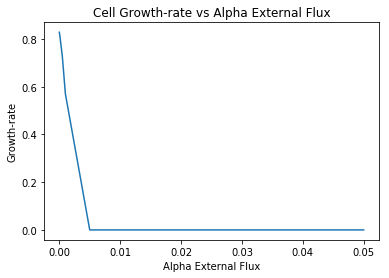

In [24]:
import matplotlib.pyplot as plt
  
# x axis values
x = Alpha
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Alpha External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs Alpha External Flux')
  
# function to show the plot
plt.show()

In [25]:
from contextlib import suppress

Alpha = [0, 0.001, 0.00102, 0.00104, 0.001045, 0.00105, 0.002]
growth_rate2 = []
for x in Alpha:
    print('\nAlpha Flux # ',x)
    me.reactions.get_by_id('DM_protein_Alpha').lower_bound = x
    me.reactions.get_by_id('DM_protein_Alpha').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate2.append(temp)
    print('Growth-rate =', growth_rate2)
    
growth_rate2


Alpha Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.137215 seconds
Finished substituting S,lb,ub in 2.252379 seconds
Finished makeME_LP in 0.357988 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.410705 seconds
Finished makeME_LP in 0.393480 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.274788 seconds
Finished makeME_LP in 0.363542 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.289625 seconds
Finished makeME_LP in 0.361925 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.280603 seconds
Finished makeME_LP in 0.368685 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.343206 seconds
Finished makeME_LP in 0.360756 seconds

Finished substituting S,lb,ub in 2.321796 seconds
Finished makeME_LP in 0.362799 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.372416 seconds
Finished makeME_LP in 0.361450 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.290285 seconds
Finished makeME_LP in 0.375129 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.379379 seconds
Finished makeME_LP in 0.373367 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.365396 seconds
Finished makeME_LP in 0.364998 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.371260 seconds
Finished makeME_LP in 0.377369 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 531.578 seconds
Growth-rate = [0.828125, 0.570

[0.828125, 0.5703125, 0.5625, 0.546875, 0.546875, 0.546875, 0]

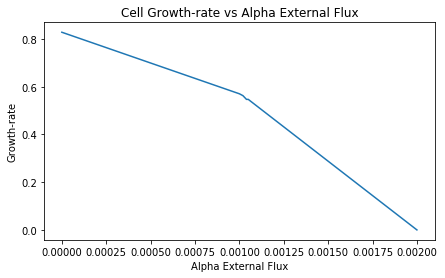

In [27]:
import matplotlib.pyplot as plt
  
# x axis values
x = Alpha
# corresponding y axis values
y = growth_rate2

plt.figure(figsize=(7,4))
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Alpha External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs Alpha External Flux')
  
# function to show the plot
plt.show()